## import libraries

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import pandas as pd
import geopandas as gpd
import osmnx
from scipy.stats import zscore


In [2]:
#make plot interactive
plt.ion()

# 1)  Social Indicator

### Load & clean data 

In [3]:
# load the necessary data here 
admin = gpd.read_file("C:/Users/charl/OneDrive/Desktop/ulster/EGM722_programming/git/egm722_project/data/Stadtteile_Hamburg.shp")
stats = pd.read_csv("C:/Users/charl/OneDrive/Desktop/ulster/EGM722_programming/git/egm722_project/data/statistics_HH21.csv",encoding="utf-8", delimiter=";",decimal="." )
#admin
#print(stats.head())

In [4]:
#rename columns
stats.columns = ['district','inhabitants', 'pop<18','%<18', 'pop>65y','%>65', 'foreignResidents', 'migration_backg', 'hh','pp_size','hh_kids', '%hh_kids','areakm2', 'pop_density','working_pop', '%working_pop', 'unemployed','%unemployed','unemployed<18','%unemployed<18', 'unemployed>65', '%unemployed>65','social_benefits', '%social_benefits','social_housing', '%social_housing']
#stats


In [5]:
#joined population data with shapefile of admin boundaries and dropped additional columns in the admin dataset
admin_pop = pd.merge(admin,stats, left_on='stadtteil_', right_on='district', how = 'inner')

admin_pop.drop(columns=['OBJECTID','bezirk', 'stadttei_1', 'stadttei_2','pp_size', '%<18', 'hh','foreignResidents', 'migration_backg','pop<18','hh_kids', '%hh_kids' ],axis=1, inplace=True)

#admin_pop
#fig, ax = plt.subplots(figsize=(24, 18))
#admin_pop.plot(ax=ax, alpha=1,linewidth=2, facecolor="none")

In [6]:
admin_pop.isnull().mean() * 100
admin_pop.dropna(subset=['%unemployed','%social_benefits','%social_housing','%unemployed>65' ], inplace=True)

#admin_pop.dropna(inplace=True)
#admin_pop.plot()
admin_pop

,bezirk_nam,stadtteil_,stadttei_2,SHAPE_Leng,SHAPE_Area,geometry,district,inhabitants,%<18,pop>65y,...,unemployed,%unemployed,unemployed<18,%unemployed<18,unemployed>65,%unemployed>65,social_benefits,%social_benefits,social_housing,%social_housing
0,Hamburg-Mitte,Hamburg-Altstadt,101,9028.180532,3.676562e+06,"POLYGON ((1113865.821 7085107.333, 1113978.324...",Hamburg-Altstadt,2358,12.6,257,...,98,5.3,NaN,NaN,14,5.7,193,8.2,176,12.4
1,Hamburg-Mitte,HafenCity,102,13902.691334,6.860720e+06,"POLYGON ((1113043.882 7082944.386, 1112901.932...",HafenCity,6302,18.8,598,...,144,3.1,NaN,NaN,14,2.7,309,4.9,799,24.9
2,Hamburg-Mitte,Neustadt,103,11133.923114,6.395226e+06,"POLYGON ((1112508.476 7085835.161, 1112319.283...",Neustadt,12611,11.2,1.894.00,...,494,5.2,28,2.9,104,6.5,911,7.2,967,12.6
3,Hamburg-Mitte,St. Pauli,104,15968.675123,6.343533e+06,"POLYGON ((1109116.549 7084327.397, 1109001.027...",St. Pauli,21803,13.1,2.245.00,...,1.330.00,7.8,65,3.4,282,10.7,2.708.00,12.4,1.485.00,11.7
4,Hamburg-Mitte,St. Georg,105,9795.650670,5.155061e+06,"POLYGON ((1114563.830 7085359.663, 1114541.839...",St. Georg,11467,10.4,1.602.00,...,489,5.5,33,2.8,103,7.0,841,7.3,852,13.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Harburg,Eißendorf,709,31084.353643,2.346095e+07,"POLYGON ((1109757.222 7067980.513, 1109761.232...",Eißendorf,24780,17.3,4.880.00,...,885,5.4,77,2.7,160,4.9,2.391.00,9.6,546,4.4
96,Harburg,Heimfeld,710,36977.354895,3.662622e+07,"POLYGON ((1109614.271 7070047.756, 1109575.947...",Heimfeld,22255,17.1,3.398.00,...,989,6.3,94,3.4,168,6.6,2.544.00,11.4,1.849.00,17.3
98,Harburg,Hausbruch,713,34659.184329,2.770431e+07,"POLYGON ((1101387.092 7070743.160, 1101380.353...",Hausbruch,16753,19.1,3.493.00,...,792,7.5,67,3.5,183,7.1,2.261.00,13.5,1.104.00,15.1
99,Harburg,Neugraben-Fischbek,714,42482.635108,6.344999e+07,"POLYGON ((1096583.594 7064715.537, 1096542.372...",Neugraben-Fischbek,33126,21.8,6.256.00,...,1.445.00,7.0,117,3.3,252,6.2,4.193.00,12.7,1.107.00,7.7


%unemployed          2.429636
%social_benefits     6.941654
%social_housing     10.981457
%unemployed>65       2.461121
dtype: float64

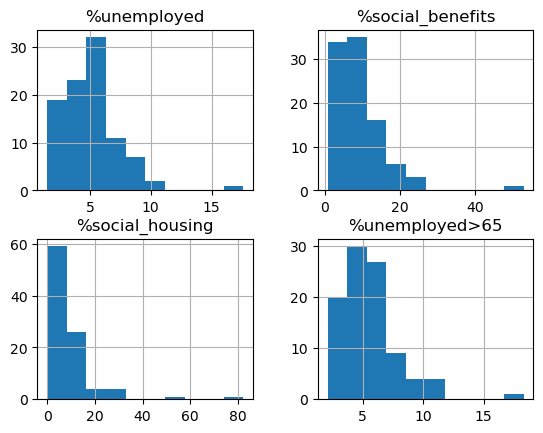

In [7]:
# this line of code first subsets the dataframe so that only the columns relevant to the further anylsis (social status) are maintained
#this euqally makes sure to avoid non numeric values for normalization later on
#and calculates standard deviation to inform about the distribution
social_stats = admin_pop[['%unemployed','%social_benefits','%social_housing','%unemployed>65' ]]#std()

social_stats.hist()
social_stats.std()

In [8]:
#Uses the scipy Library in Python to calculate the z-score which helps to standardizes the values each column 

z_scores_admin_pop = admin_pop[['%unemployed','%social_benefits','%social_housing','%unemployed>65']].apply(zscore)

print(z_scores_admin_pop.std())

%unemployed         1.005305
%social_benefits    1.005305
%social_housing     1.005305
%unemployed>65      1.005305
dtype: float64


In [9]:
#z_scores_admin_pop

### Analysis

In [9]:
# calculates the mean of the columns
mean_socstats = z_scores_admin_pop[['%unemployed','%social_benefits','%social_housing','%unemployed>65', ]].mean(axis=1)
z_scores_admin_pop['mean_socstats'] = mean_socstats


In [10]:
#groups / classifies the results into percentile of the respective column (equal quantiles 0 -4 (e.g. 0= lowest 20th quantile of mean / to  - 4 within highest 20th quantil))
z_scores_admin_pop ['qt_soc_stats'] = pd.qcut(z_scores_admin_pop ['mean_socstats'],5,labels=[0, 1, 2, 3, 4])


In [11]:
# add text descripzion as an additional column
z_scores_admin_pop['status'] = ['very low' if x == 0 else
                       'low' if x == 1 else
                       'medium' if x == 2 else
                       'high' if x == 3 else
                       'very high' for x in z_scores_admin_pop['qt_soc_stats']]

z_scores_admin_pop.head()

,%unemployed,%social_benefits,%social_housing,%unemployed>65,mean_socstats,qt_soc_stats,status
0,0.051394,-0.122718,0.355872,0.042137,0.081671,3,high
1,-0.858895,-0.600631,1.500193,-1.183286,-0.285655,1,low
2,0.010018,-0.267540,0.374181,0.368917,0.121394,3,high
3,1.085814,0.485535,0.291790,2.084510,0.986912,4,very high
4,0.134148,-0.253058,0.429108,0.573154,0.220838,3,high


In [12]:
#merge the 2 frames to be able to plot the data later on
admin_socstats = pd.merge(admin_pop, z_scores_admin_pop, left_index=True, right_index=True)
admin_socstats.head()

,bezirk_nam,stadtteil_,stadttei_2,SHAPE_Leng,SHAPE_Area,geometry,district,inhabitants,%<18,pop>65y,...,%social_benefits_x,social_housing,%social_housing_x,%unemployed_y,%social_benefits_y,%social_housing_y,%unemployed>65_y,mean_socstats,qt_soc_stats,status
0,Hamburg-Mitte,Hamburg-Altstadt,101,9028.180532,3.676562e+06,"POLYGON ((1113865.821 7085107.333, 1113978.324...",Hamburg-Altstadt,2358,12.6,257,...,8.2,176,12.4,0.051394,-0.122718,0.355872,0.042137,0.081671,3,high
1,Hamburg-Mitte,HafenCity,102,13902.691334,6.860720e+06,"POLYGON ((1113043.882 7082944.386, 1112901.932...",HafenCity,6302,18.8,598,...,4.9,799,24.9,-0.858895,-0.600631,1.500193,-1.183286,-0.285655,1,low
2,Hamburg-Mitte,Neustadt,103,11133.923114,6.395226e+06,"POLYGON ((1112508.476 7085835.161, 1112319.283...",Neustadt,12611,11.2,1.894.00,...,7.2,967,12.6,0.010018,-0.267540,0.374181,0.368917,0.121394,3,high
3,Hamburg-Mitte,St. Pauli,104,15968.675123,6.343533e+06,"POLYGON ((1109116.549 7084327.397, 1109001.027...",St. Pauli,21803,13.1,2.245.00,...,12.4,1.485.00,11.7,1.085814,0.485535,0.291790,2.084510,0.986912,4,very high
4,Hamburg-Mitte,St. Georg,105,9795.650670,5.155061e+06,"POLYGON ((1114563.830 7085359.663, 1114541.839...",St. Georg,11467,10.4,1.602.00,...,7.3,852,13.2,0.134148,-0.253058,0.429108,0.573154,0.220838,3,high


In [14]:
#save the final data set to cvs
admin_socstats.describe


<bound method NDFrame.describe of         bezirk_nam          stadtteil_ stadttei_2    SHAPE_Leng    SHAPE_Area   
0    Hamburg-Mitte    Hamburg-Altstadt        101   9028.180532  3.676562e+06  \
1    Hamburg-Mitte           HafenCity        102  13902.691334  6.860720e+06   
2    Hamburg-Mitte            Neustadt        103  11133.923114  6.395226e+06   
3    Hamburg-Mitte           St. Pauli        104  15968.675123  6.343533e+06   
4    Hamburg-Mitte           St. Georg        105   9795.650670  5.155061e+06   
..             ...                 ...        ...           ...           ...   
95         Harburg           Eißendorf        709  31084.353643  2.346095e+07   
96         Harburg            Heimfeld        710  36977.354895  3.662622e+07   
98         Harburg           Hausbruch        713  34659.184329  2.770431e+07   
99         Harburg  Neugraben-Fischbek        714  42482.635108  6.344999e+07   
101        Harburg          Neuenfelde        716  31946.432527  4.424464e+

### VISUALIZATION

In [ ]:
#plot output
admin_socstats.plot("status", cmap="Reds", legend=True)  


# 2) Environmental Indicators
uses noise, green areas (air pollution?, surface temperature? as indicator)

In [17]:
#load the data
noise = gpd.read_file("C:/Users/charl/OneDrive/Desktop/ulster/EGM722_programming/git/egm722_project/data/Laermkarten_HH_2018-11-19.shp")
buildings = gpd.read_file("C:/Users/charl/OneDrive/Desktop/ulster/EGM722_programming/git/egm722_project/data/Gebaeude_Hamburg.shp")
green_areas = gpd.read_file("C:/Users/charl/OneDrive/Desktop/ulster/EGM722_programming/git/egm722_project/data/Oeffentliche_Gruenanlage_Hamburg.shp")

In [18]:
# function to checks crs of different layers and reproject to epgs:Hamburg, GE to prepare for joining later on EPSG:25832
def reproject_to_local_epsg(gdf):
    # Check the CRS of the input GeoDataFrame
    print('Original CRS:', gdf.crs)

    # Reproject the GeoDataFrame to EPSG 25832
    gdf_reproj = gdf.to_crs(epsg=25832)

    # Check the CRS of the output GeoDataFrame
    print('Reprojected CRS:', gdf_reproj.crs)

    return gdf_reproj

# apply function
admin_pop_reproj = reproject_to_local_epsg(admin_pop)
noise_reproj = reproject_to_local_epsg(noise)
housing_reproj = reproject_to_local_epsg(buildings)
green_areas_reproj = reproject_to_local_epsg(green_areas)


Original CRS: EPSG:3857
Reprojected CRS: EPSG:25832
Original CRS: EPSG:25832
Reprojected CRS: EPSG:25832
Original CRS: EPSG:3857
Reprojected CRS: EPSG:25832
Original CRS: EPSG:3857
Reprojected CRS: EPSG:25832


### Green areas 

In [21]:
#green_areas_reproj
green_areas_reproj.columns

Index(['OBJECTID', 'dgpkey', 'benennung', 'gesamtan_1', 'bezirk', 'stadtteil',
       'ortsteil', 'gemarkung', 'verwaltung', 'flaeche_ha', 'flaeche_qm',
       'stand', 'SHAPE_Leng', 'SHAPE_Area', 'geometry'],
      dtype='object')

In [20]:
#for green areas delete the values with code 10 - playground according to Alkis key and drop some of the unimportant columns
green_areas_reproj = green_areas_reproj[green_areas_reproj.nutzung != 10]
green_areas_reproj.drop(columns=['veroeffent', 'nutzung', 'nutz_code' ,'herrichtun', 'gesamtanla','aktualitae','idnr','belegenh_1','belegenhei','quelle_dat'],axis=1, inplace=True)

green_areas_reproj.head()

,OBJECTID,dgpkey,benennung,gesamtan_1,bezirk,stadtteil,ortsteil,gemarkung,verwaltung,flaeche_ha,flaeche_qm,stand,SHAPE_Leng,SHAPE_Area,geometry
0,1,51580005,NaN,Schutz-Straßenbegleitgrün Rev 3,Wandsbek,Bramfeld,515,546,Stadtgrün,1.3090,13090,2021-02-16,1813.268251,37135.153073,"POLYGON ((571682.385 5940442.628, 571927.493 5..."
1,2,51550113,NaN,Osterbekoberlauf,Wandsbek,Bramfeld,515,546,Stadtgrün,0.4478,4478,2021-02-16,920.409622,12697.549886,"POLYGON ((572254.058 5939481.930, 572254.220 5..."
2,3,52650280,NaN,Stellau Grün,Wandsbek,Rahlstedt,526,544,Stadtgrün,0.2839,2839,2021-02-16,637.414887,8047.566252,"POLYGON ((577689.808 5938869.601, 577701.406 5..."
3,4,52650280,NaN,Stellau Grün,Wandsbek,Rahlstedt,526,544,Stadtgrün,0.0746,746,2021-02-16,185.305657,2116.281875,"POLYGON ((577695.717 5938789.061, 577671.599 5..."
4,5,50950039,NaN,Gartenstadt,Wandsbek,Wandsbek,509,552,AGV,0.0356,356,2021-02-16,252.935327,1008.046963,"POLYGON ((571054.670 5938638.040, 571054.878 5..."


Index(['OBJECTID', 'gebaeudefu', 'bauweise', 'anzahlDerO', 'dachform',
       'grundflaec', 'SHAPE_Area', 'geometry'],
      dtype='object')

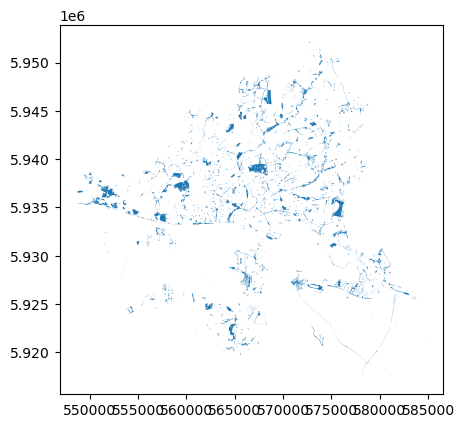

In [24]:
green_areas_reproj.plot()

housing_reproj.columns

In [23]:
# filter out any non-residential housing from data set according to ALKIS Key (1000 and 1010 )
housing_reproj['gebaeudefu'] = housing_reproj['gebaeudefu'].astype(int)

print(housing_reproj['gebaeudefu'].dtype)
housing_reproj.drop(columns=['anzahlDerU', 'lageZurErd', 'dachart', 'SHAPE_Leng'],axis=1, inplace=True)


int32


KeyError: "['anzahlDerU', 'lageZurErd', 'dachart', 'SHAPE_Leng'] not found in axis"

In [25]:

housing_reproj = housing_reproj[(housing_reproj['gebaeudefu'] == 1010) | (housing_reproj['gebaeudefu'] == 1000)]
housing_reproj.head()

,OBJECTID,gebaeudefu,bauweise,anzahlDerO,dachform,grundflaec,SHAPE_Area,geometry
3,4,1010,1100,2,3100,181.0,508.029040,"POLYGON ((577633.748 5917580.434, 577631.911 5..."
5,6,1010,1100,2,3100,149.0,418.245752,"POLYGON ((577328.357 5917888.436, 577330.146 5..."
7,8,1010,1200,2,3100,212.0,594.692757,"POLYGON ((577777.337 5917528.293, 577760.505 5..."
8,9,1010,1100,1,3100,44.0,124.225610,"POLYGON ((577927.634 5917499.514, 577921.216 5..."
10,11,1010,1200,3,3100,238.0,669.161637,"POLYGON ((577367.964 5917779.528, 577355.622 5..."


In [26]:
#calculates area statistics of green spaces / district = stadtteil 2. calculate area / inhabitants
green_areas_reproj.groupby(['stadtteil'])['flaeche_ha'].sum() # sum of area in ha
green_areas_reproj.groupby(['stadtteil'])['flaeche_ha'].mean() # mean area in ha
green_areas_reproj.groupby(['stadtteil'])['benennung'].count()  # bennenung: counts  of grean areas per district


stadtteil
Allermöhe              7
Alsterdorf             6
Altengamme             0
Altona-Altstadt       37
Altona-Nord            1
                    ... 
Wellingsbüttel         2
Wilhelmsburg         105
Wilstorf              13
Winterhude            52
Wohldorf-Ohlstedt      4
Name: benennung, Length: 96, dtype: int64

In [54]:
#2. calculate green area / inhabitants -- for that add some of the colums from admin data to green areas data set???
#green_areas_reproj['inhabitants']


#join = gpd.sjoin(green_areas_reproj, admin_pop_reproj, how='inner', lsuffix='left', rsuffix='right') # perform the spatial join

# Merge the two datasets based on the "stadteil" or "stadteil_" columns
df1 = green_areas_reproj.merge(admin_pop_reproj[['inhabitants', 'stadtteil_']], how = 'left',
                left_on = 'stadtteil', right_on = 'stadtteil_').drop(columns = ['stadtteil']) #                          how='left', on=['stadtteil', 'stadtteil_'])

df1
#join


,OBJECTID,dgpkey,benennung,gesamtan_1,bezirk,ortsteil,gemarkung,verwaltung,flaeche_ha,flaeche_qm,stand,SHAPE_Leng,SHAPE_Area,geometry,inhabitants,stadtteil_
0,1,51580005,NaN,Schutz-Straßenbegleitgrün Rev 3,Wandsbek,515,546,Stadtgrün,1.3090,13090,2021-02-16,1813.268251,37135.153073,"POLYGON ((571682.385 5940442.628, 571927.493 5...",52573.0,Bramfeld
1,2,51550113,NaN,Osterbekoberlauf,Wandsbek,515,546,Stadtgrün,0.4478,4478,2021-02-16,920.409622,12697.549886,"POLYGON ((572254.058 5939481.930, 572254.220 5...",52573.0,Bramfeld
2,3,52650280,NaN,Stellau Grün,Wandsbek,526,544,Stadtgrün,0.2839,2839,2021-02-16,637.414887,8047.566252,"POLYGON ((577689.808 5938869.601, 577701.406 5...",92369.0,Rahlstedt
3,4,52650280,NaN,Stellau Grün,Wandsbek,526,544,Stadtgrün,0.0746,746,2021-02-16,185.305657,2116.281875,"POLYGON ((577695.717 5938789.061, 577671.599 5...",92369.0,Rahlstedt
4,5,50950039,NaN,Gartenstadt,Wandsbek,509,552,AGV,0.0356,356,2021-02-16,252.935327,1008.046963,"POLYGON ((571054.670 5938638.040, 571054.878 5...",37340.0,Wandsbek
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3597,3344,32165028,349 Gartenpark Vogt-Kölln-Straße,NaN,Eimsbüttel,321,0,Flächen des Bezirks - Stadtgrün,2.5748,25748,2021-02-16,3788.331264,73041.471144,"POLYGON ((561842.274 5939963.148, 561837.588 5...",26955.0,Stellingen
3598,3345,51665022,552 Fieckendorf v. 1900 / 561 Steilshooper Höh...,Eichenlohweg - Kleingärten,Wandsbek,516,0,"Grundstücke Dritter, Erbbaurecht - Wohnungserb...",3.0034,30034,2021-02-16,9315.971945,85244.364952,"POLYGON ((569683.702 5941310.708, 569630.938 5...",19662.0,Steilshoop
3599,3346,51565013,545 Lot uns in Ruh,Seebek - Kleingärten,Wandsbek,515,0,Flächen des Bezirks - Stadtgrün,0.5127,5127,2021-02-16,1795.332476,14550.447085,"POLYGON ((570681.999 5941014.721, 570664.543 5...",52573.0,Bramfeld
3600,3347,43265024,460 Fasanenmoor,NaN,Hamburg-Nord,432,0,Allgemeines Grundvermögen ohne Erbbaurecht,1.3596,13596,2021-02-16,829.603798,38679.489308,"POLYGON ((566868.542 5946842.585, 566875.830 5...",46142.0,Langenhorn


In [ ]:
#dissolve and add colums to data 


#add stats to data set to plot later

In [52]:
#join = gpd.sjoin(green_areas_reproj, housing_reproj, how='inner', lsuffix='left', rsuffix='right') # perform the spatial join
join # show the joined table

,OBJECTID,dgpkey,benennung,gesamtan_1,bezirk,stadtteil,ortsteil,gemarkung,verwaltung,flaeche_ha,...,unemployed,%unemployed,unemployed<18,%unemployed<18,unemployed>65,%unemployed>65,social_benefits,%social_benefits,social_housing,%social_housing
0,1,51580005,NaN,Schutz-Straßenbegleitgrün Rev 3,Wandsbek,Bramfeld,515,546,Stadtgrün,1.3090,...,2.133.00,6.2,121,2.5,513,6.4,5.037.00,9.6,1.778.00,6.1
1,2,51550113,NaN,Osterbekoberlauf,Wandsbek,Bramfeld,515,546,Stadtgrün,0.4478,...,2.133.00,6.2,121,2.5,513,6.4,5.037.00,9.6,1.778.00,6.1
42,43,51550364,NaN,Siedlung Karlshöhe,Wandsbek,Bramfeld,515,0,Stadtgrün,0.2355,...,2.133.00,6.2,121,2.5,513,6.4,5.037.00,9.6,1.778.00,6.1
51,52,51750134,NaN,Grüner Jäger,Wandsbek,Wellingsbüttel,517,531,Stadtgrün,14.1343,...,2.133.00,6.2,121,2.5,513,6.4,5.037.00,9.6,1.778.00,6.1
62,63,42850255,Seebek Grünzug,U-Bahn-Grünzug Barmbek,Hamburg-Nord,Barmbek-Nord,428,453,Stadtgrün,0.2334,...,2.133.00,6.2,121,2.5,513,6.4,5.037.00,9.6,1.778.00,6.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2976,2977,10450001,Lohsepark,Gesamtanlagenname fehlt,Hamburg-Mitte,HafenCity,104,0,Hafencity,0.3238,...,144,3.1,NaN,NaN,14,2.7,309,4.9,799,24.9
2977,2978,10450001,Lohsepark,Gesamtanlagenname fehlt,Hamburg-Mitte,HafenCity,104,0,Hafencity,0.1544,...,144,3.1,NaN,NaN,14,2.7,309,4.9,799,24.9
3127,3128,10450001,Lohsepark,Gesamtanlagenname fehlt,Hamburg-Mitte,HafenCity,104,0,Hafencity,3.6426,...,144,3.1,NaN,NaN,14,2.7,309,4.9,799,24.9
3253,3254,10450002,Baakenpark,Baakenpark,Hamburg-Mitte,HafenCity,104,0,Hafencity,1.6258,...,144,3.1,NaN,NaN,14,2.7,309,4.9,799,24.9


In [ ]:
#admin_pop_reproj['inhabitants']=admin_pop_reproj['inhabitants'].astype(float)

